<a href="https://colab.research.google.com/github/MulinSzeto/MIE1624-intro-to-DataScience-Analytics/blob/main/A3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating University Program Curriculumn based on Clustering of Skills in Job Postings


### Import Python libraries

In [ ]:
import numpy as np
import pandas as pd
import os
import requests
import matplotlib as plt
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
## Machine Learning libraries
from sklearn.preprocessing import normalize
import scipy.cluster.hierarchy as sch
from numpy import zeros as sci_zeros
from scipy.spatial.distance import euclidean
from scipy.cluster.hierarchy import ClusterWarning
from warnings import simplefilter
simplefilter("ignore", ClusterWarning)

### Q1a - Extracted Skills using openai api key from job postings

In [ ]:
# Sample dataset file name (replace this sample dataset with the dataset to be used in Assignment 3)
filename_data = '/content/Data_Scientist_Canada_US_Remote.csv'

# Read csv file (dataset)
results = pd.read_csv(filename_data)

# Change column names
results.rename(columns={'Job_Title': 'Title', 'Company_Name': 'Company', 'Job_Description': 'Descriptions'}, inplace=True)

# Filter out missing descriptions and make sure it's a string
valid_results = results.dropna(subset=["Descriptions"]).copy()

In [ ]:
from openai import OpenAI

# Connect to DeepSeek
client = OpenAI(
    api_key="",
    base_url="https://api.deepseek.com"
)

def extract_skills_from_text(text, model="deepseek-chat"):
    prompt = f"""
Extract a list of all the skills mentioned in the following job description.
Include both hard and soft skills. Return the skills as a single comma-separated list — no explanations, no formatting, no extra text.

Job Description:
{text}
"""
    try:
        response = client.chat.completions.create(
            model=model,
            messages=[{"role": "user", "content": prompt}],
            temperature=0,
            stream=False
        )
        return response.choices[0].message.content
    except Exception as e:
        return str(e)

In [ ]:
# Run on a small sample

sample_df = valid_results.sample(200, random_state=42).copy()

results = []

for i, row in sample_df.iterrows():
    desc = row["Descriptions"]
    try:
        skills = extract_skills_from_text(desc[:1000])
        results.append(skills)
    except Exception as e:
        results.append(None)

sample_df["extracted_skills"] = results

In [ ]:
sample_df[["Descriptions", "extracted_skills"]].head()

,Descriptions,extracted_skills
7616,We are a well-funded Series A startup on a mis...,"FP&A, forecasting, planning, financial analysi..."
3682,Position Purpose:\nThe Product Manager (PM) po...,"d teams, and third-party partners \nIdentifie..."
10931,We are seeking an experienced software enginee...,"Python, Django, Django ORM, GraphQL, performan..."
640,We are looking for a Team Lead who will play t...,"team leadership, analytics product ownership, ..."
10011,\n About Backblaze \n Backblaze makes storing ...,"data storage, cloud computing, software develo..."


In [ ]:
sample_df.to_csv("openai_skill_extraction_output.csv", index=False)

### Q1b - Visualizations

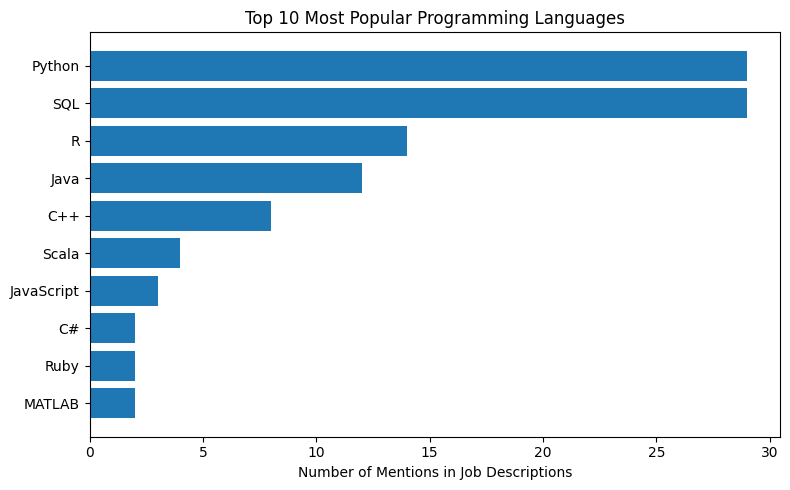

In [ ]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

# Reload the data
df = pd.read_csv("/content/openai_skill_extraction_output.csv")
df = df.dropna(subset=["extracted_skills"]).copy()

# List of common programming languages
programming_languages = [
    "Python", "R", "SQL", "Java", "JavaScript", "C++", "C#", "Scala", "Go", "Ruby",
    "PHP", "MATLAB", "Swift", "Perl", "Kotlin", "TypeScript"
]

# Flatten all skills
all_skills = [s.strip() for sublist in df["extracted_skills"].dropna().apply(lambda x: x.split(",")) for s in sublist]
skill_counts = Counter(all_skills)

# Count programming languages
language_counts = {lang: skill_counts.get(lang, 0) for lang in programming_languages}
top_langs = sorted(language_counts.items(), key=lambda x: x[1], reverse=True)[:10]

# Plot
langs, counts = zip(*top_langs)
plt.figure(figsize=(8, 5))
plt.barh(langs[::-1], counts[::-1])
plt.title("Top 10 Most Popular Programming Languages")
plt.xlabel("Number of Mentions in Job Descriptions")
plt.tight_layout()
plt.show()


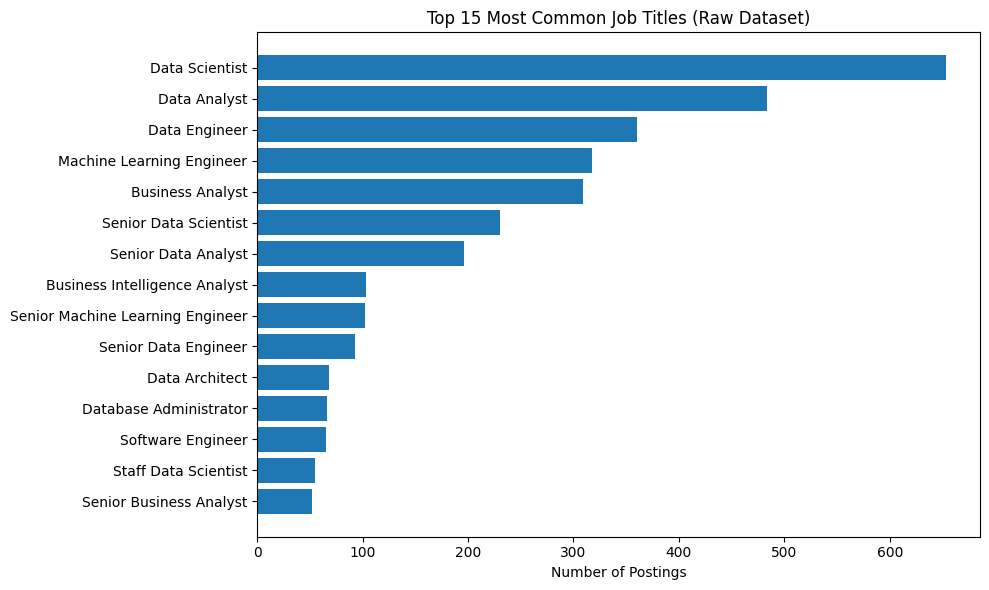

In [ ]:
raw_df = pd.read_csv("/content/Data_Scientist_Canada_US_Remote.csv")

# Drop missing values in 'Title' column and count frequency
raw_title_counts = raw_df["Title"].dropna().value_counts().head(15)

# Plot top job titles from raw dataset
plt.figure(figsize=(10, 6))
plt.barh(raw_title_counts.index[::-1], raw_title_counts.values[::-1])
plt.title("Top 15 Most Common Job Titles (Raw Dataset)")
plt.xlabel("Number of Postings")
plt.tight_layout()
plt.show()

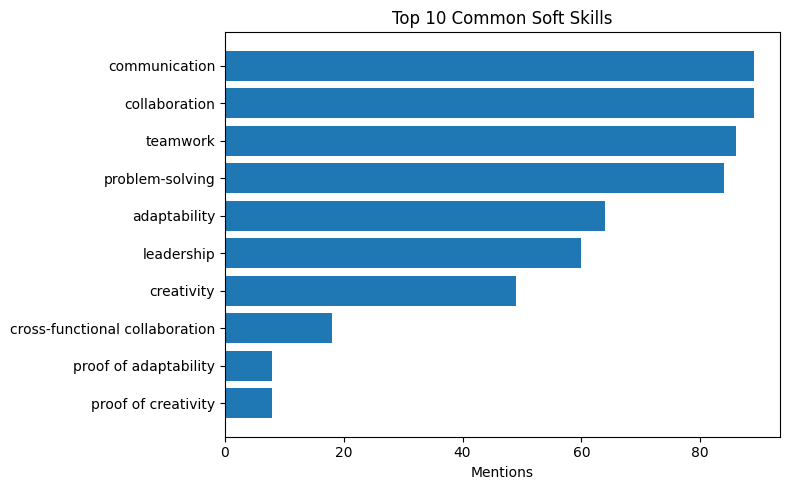

In [ ]:
soft_keywords = ["communication", "teamwork", "leadership", "adaptability", "creativity", "collaboration", "problem-solving"]
soft_skill_counts = {skill: count for skill, count in skill_counts.items() if any(k in skill.lower() for k in soft_keywords)}
top_soft_skills = sorted(soft_skill_counts.items(), key=lambda x: x[1], reverse=True)[:10]

# Plot
skills, counts = zip(*top_soft_skills)
plt.figure(figsize=(8, 5))
plt.barh(skills[::-1], counts[::-1])
plt.title("Top 10 Common Soft Skills")
plt.xlabel("Mentions")
plt.tight_layout()
plt.show()


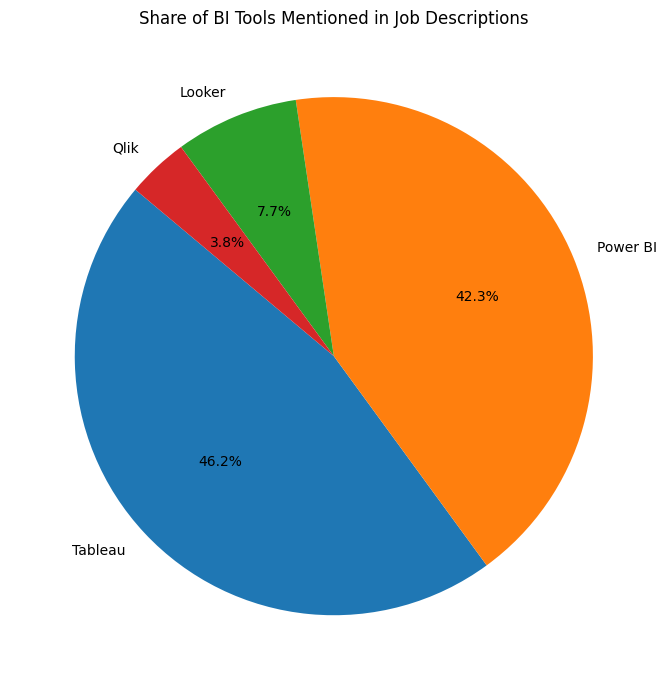

In [ ]:
# List of BI tools
bi_tools = ["Power BI", "Tableau", "Looker", "Qlik", "Domo", "Sisense", "Google Data Studio", "MicroStrategy"]

# Count BI tool mentions
all_skills = [s.strip() for sublist in df["extracted_skills"].dropna().apply(lambda x: x.split(",")) for s in sublist]
skill_counts = Counter(all_skills)

# Compute % usage
total_postings = len(df)
bi_tool_freq = {tool: skill_counts.get(tool, 0) for tool in bi_tools}
bi_tool_pct = {tool: (count / total_postings) * 100 for tool, count in bi_tool_freq.items() if count > 0}

tools, percentages = zip(*sorted(bi_tool_pct.items(), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(7, 7))
plt.pie(percentages, labels=tools, autopct='%1.1f%%', startangle=140)
plt.title("Share of BI Tools Mentioned in Job Descriptions")
plt.tight_layout()
plt.show()


### Q2 - Hierarchical clustering

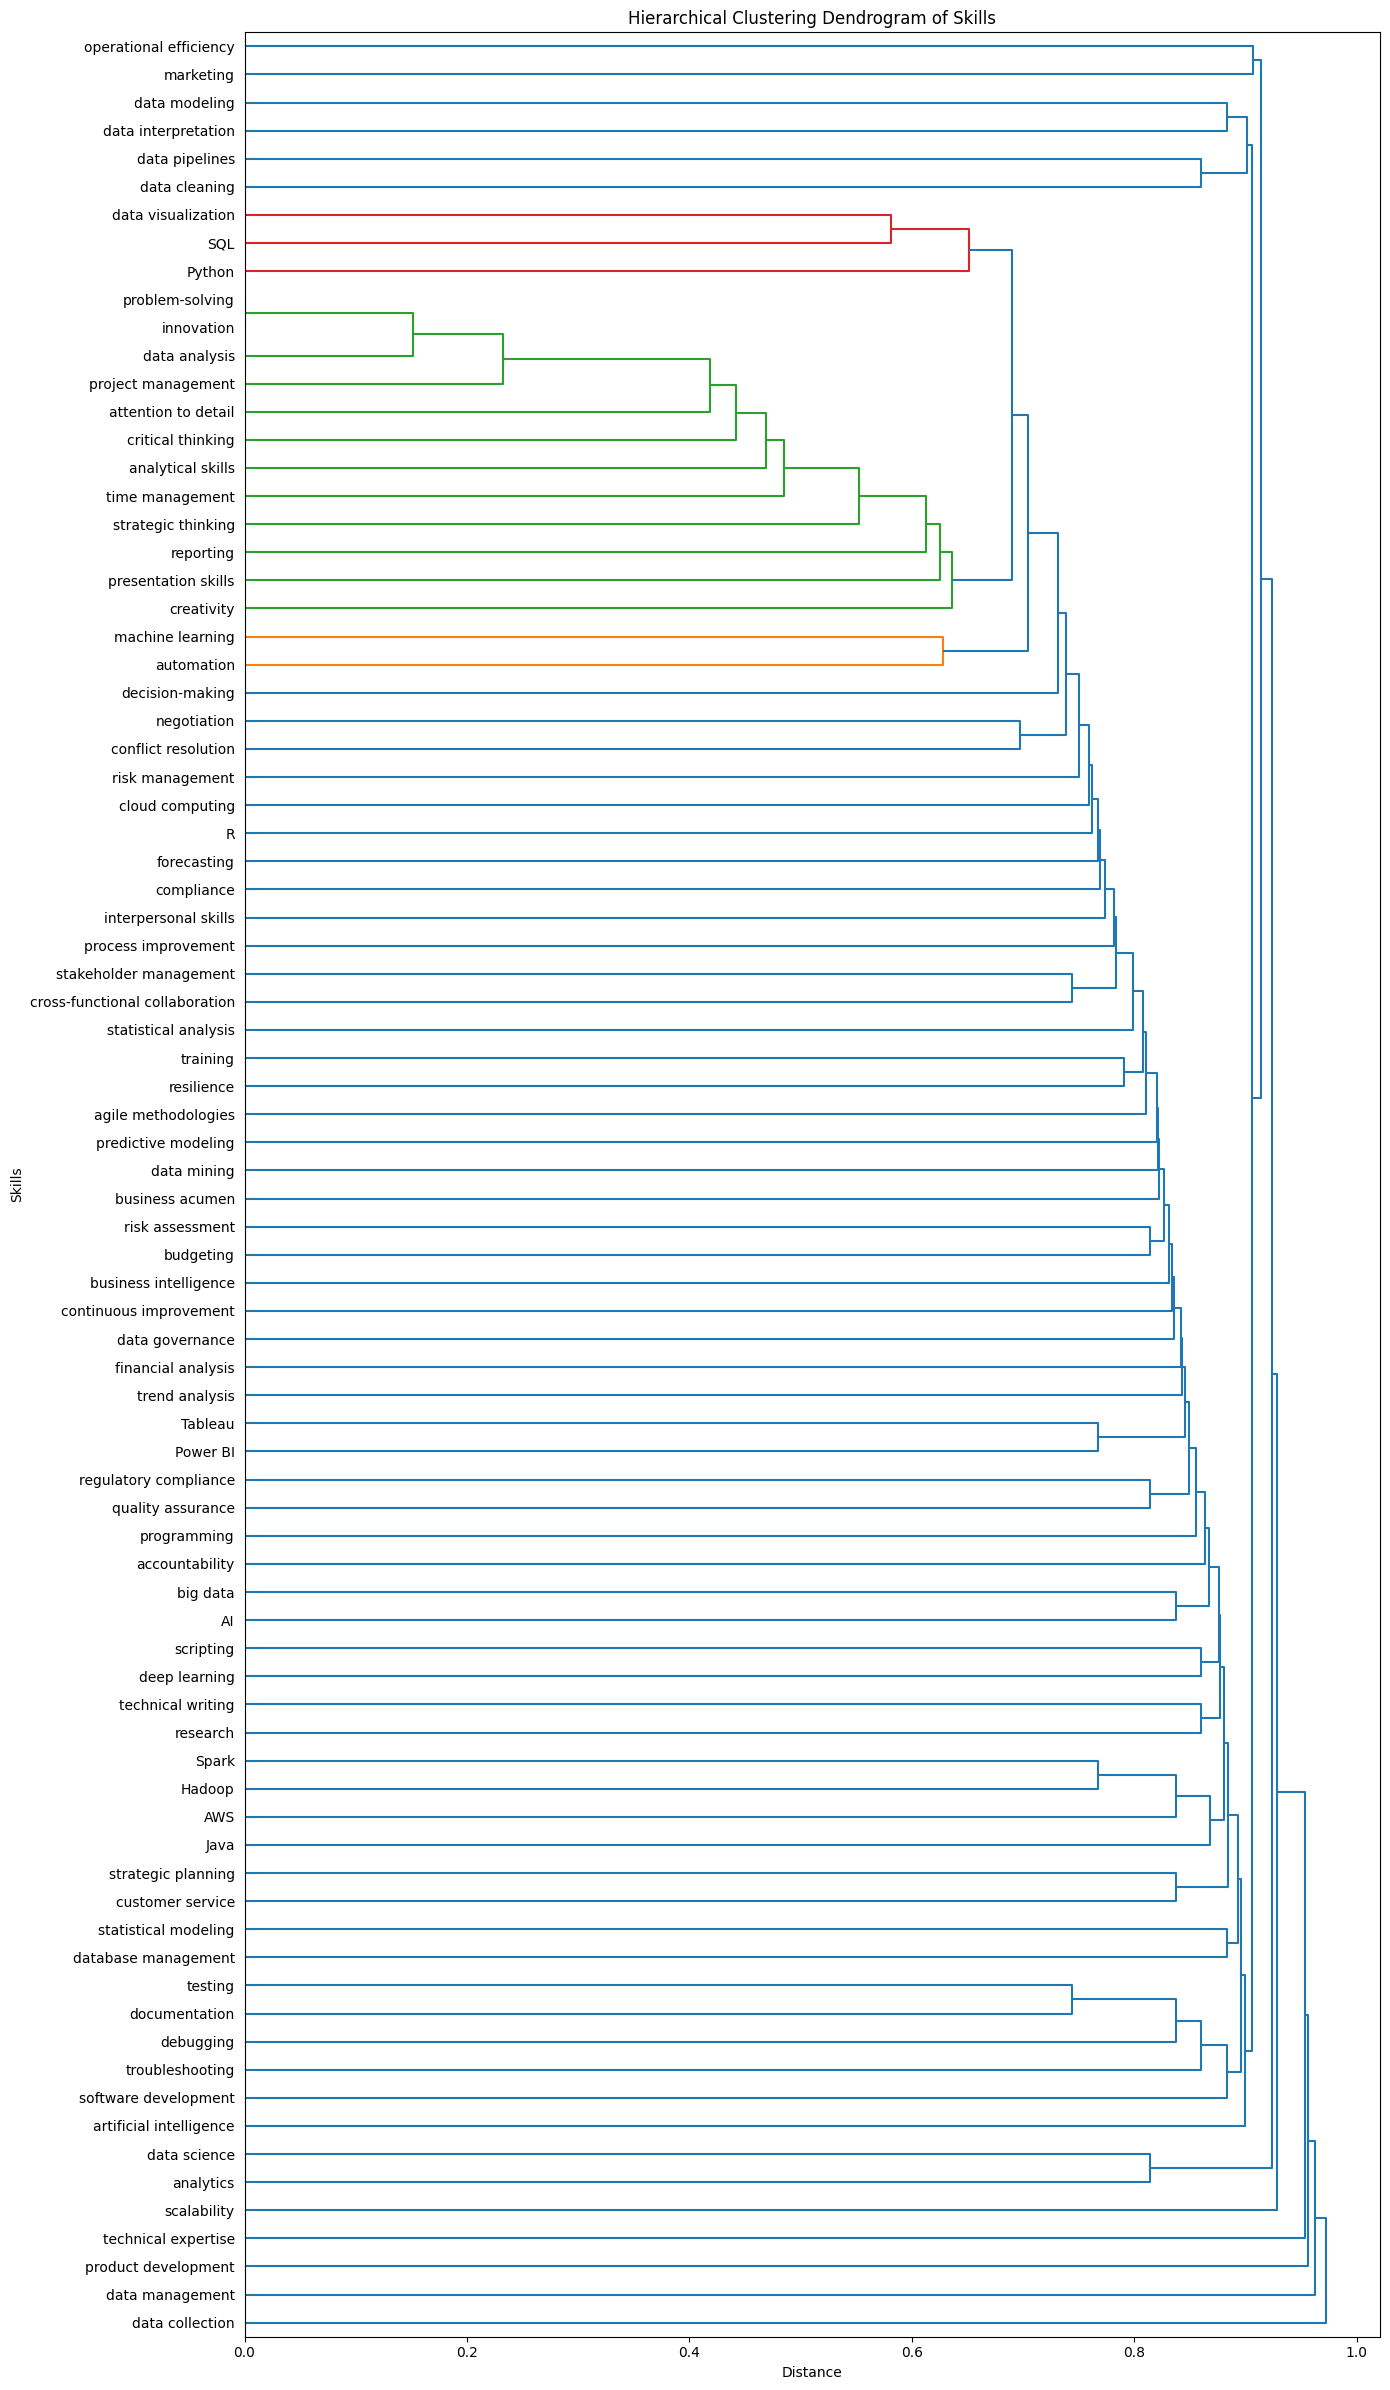

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

# Load the Cleaned Dataset
df = pd.read_csv("/content/openai_skill_extraction_output.csv")
clean_df = df.dropna(subset=["extracted_skills"]).copy()
clean_df["skill_list"] = clean_df["extracted_skills"].apply(lambda x: [s.strip() for s in str(x).split(",") if s.strip()])

# Binary Skill Matrix
mlb = MultiLabelBinarizer()
binary_matrix = pd.DataFrame(
    mlb.fit_transform(clean_df["skill_list"]),
    columns=mlb.classes_,
    index=clean_df.index
)

# Exclude Non-Teachable or Soft-only Skills
excluded_skills = {
    "remote work", "mentoring", "coaching", "teamwork", "adaptability",
    "collaboration", "communication", "dedication", "work ethic", "integrity",
    "soft skills", "leadership", "self-starter", "initiative", "organization",
    "curiosity", "trust", "honesty", "transparency", "motivation", "patience"
}

# Filter Frequently Occurring Skills (min_occurrence ≥ 10)
skill_counts = binary_matrix.sum(axis=0)
frequent_skills = skill_counts[skill_counts >= 10].index
filtered_skills = [s for s in frequent_skills if s.lower() not in excluded_skills]
filtered_binary = binary_matrix[filtered_skills]

# Build Co-occurrence and Distance Matrix
co_occurrence = filtered_binary.T.dot(filtered_binary)
np.fill_diagonal(co_occurrence.values, 0)
max_co = co_occurrence.values.max()
distance_matrix = 1 - (co_occurrence / max_co)
distance_matrix_df = pd.DataFrame(distance_matrix, index=co_occurrence.index, columns=co_occurrence.columns)

# Hierarchical Clustering
condensed_dist = squareform(distance_matrix, checks=False)
linkage_matrix = linkage(condensed_dist, method='average')
labels = fcluster(linkage_matrix, 12, criterion='maxclust')

# Plot the dendrogram
plt.figure(figsize=(14, 24))
dendrogram(
    linkage_matrix,
    labels=distance_matrix_df.columns,
    orientation='right',
    leaf_rotation=0,
    leaf_font_size=10
)
plt.title("Hierarchical Clustering Dendrogram of Skills")
plt.xlabel("Distance")
plt.ylabel("Skills")
plt.tight_layout()
plt.show()


In [ ]:
# Extract Largest Cluster for Manual Splitting
skill_clusters_clean = pd.DataFrame({
    "Skill": distance_matrix_df.columns,
    "Cluster": labels
}).sort_values("Cluster")

largest_cluster_id = skill_clusters_clean["Cluster"].value_counts().idxmax()
largest_cluster_skills = skill_clusters_clean[skill_clusters_clean["Cluster"] == largest_cluster_id]["Skill"].tolist()
largest_cluster_skills

['Hadoop',
 'AI',
 'Power BI',
 'Python',
 'R',
 'AWS',
 'SQL',
 'Spark',
 'accountability',
 'Tableau',
 'agile methodologies',
 'analytical skills',
 'attention to detail',
 'Java',
 'continuous improvement',
 'big data',
 'budgeting',
 'business acumen',
 'business intelligence',
 'cloud computing',
 'compliance',
 'conflict resolution',
 'customer service',
 'creativity',
 'critical thinking',
 'cross-functional collaboration',
 'data analysis',
 'data visualization',
 'data governance',
 'automation',
 'reporting',
 'regulatory compliance',
 'project management',
 'data mining',
 'deep learning',
 'decision-making',
 'debugging',
 'database management',
 'documentation',
 'financial analysis',
 'forecasting',
 'innovation',
 'predictive modeling',
 'negotiation',
 'machine learning',
 'interpersonal skills',
 'research',
 'presentation skills',
 'programming',
 'quality assurance',
 'problem-solving',
 'process improvement',
 'strategic planning',
 'time management',
 'statistical

In [ ]:
# Manually Defined Courses from the Largest Cluster
manual_courses = [
    {
        "Course_ID": "Course 1: Data Engineering & Big Data Tools",
        "Skills": [
            "Hadoop", "Spark", "SQL", "Python", "R", "AWS", "database management",
            "scripting", "debugging"
        ]
    },
    {
        "Course_ID": "Course 2: Data Analysis & Visualization",
        "Skills": [
            "data analysis", "data visualization", "Tableau", "Power BI", "reporting",
            "statistical analysis", "statistical modeling", "forecasting",
            "quality assurance", "documentation"
        ]
    },
    {
        "Course_ID": "Course 3: Machine Learning & AI",
        "Skills": [
            "AI", "machine learning", "deep learning", "predictive modeling",
            "programming", "innovation", "research", "software development", "testing",
            "debugging", "troubleshooting"
        ]
    },
    {
        "Course_ID": "Course 4: Business Strategy & Project Management",
        "Skills": [
            "project management", "business intelligence", "business acumen",
            "strategic planning", "strategic thinking", "risk assessment", "budgeting",
            "stakeholder management", "decision-making", "compliance",
            "regulatory compliance", "process improvement", "risk management"
        ]
    }
]

# Retain Smaller Clusters from Hierarchical Clustering
remaining_clusters = skill_clusters_clean[skill_clusters_clean["Cluster"] != largest_cluster_id].copy()
grouped_remaining = remaining_clusters.groupby("Cluster")["Skill"].apply(list).reset_index()
grouped_remaining

,Cluster,Skill
0,1,"[analytics, data science]"
1,3,[artificial intelligence]
2,4,"[data cleaning, data pipelines]"
3,5,"[data interpretation, data modeling]"
4,6,[marketing]
5,7,[operational efficiency]
6,8,[scalability]
7,9,[technical expertise]
8,10,[product development]
9,11,[data management]


In [ ]:
# course IDs formed from small clusters
auto_courses = [
    {"Course_ID": "Course 5: Introduction to Data Science", "Skills": ["data science", "analytics", "analytical skills"]},
    {"Course_ID": "Course 6: Applied Data Modeling", "Skills": ["data modeling", "data interpretation", "trend analysis"]},
    {"Course_ID": "Course 7: Data Engineering Basics", "Skills": ["data pipelines", "data cleaning", "automation"]}
]

# soft-skills based course
soft_course = {
    "Course_ID": "Course 8: Professional Skills for Data Roles",
    "Skills": [
        "critical thinking", "communication", "conflict resolution",
        "attention to detail", "collaboration", "problem-solving", "interpersonal skills",
        "presentation skills"
    ]
}

# Combine all course definitions
final_courses = manual_courses + auto_courses + [soft_course]

# Convert to DataFrame for display or export
final_course_df = pd.DataFrame(final_courses)

In [ ]:
final_course_df

,Course_ID,Skills
0,Course 1: Data Engineering & Big Data Tools,"[Hadoop, Spark, SQL, Python, R, AWS, database ..."
1,Course 2: Data Analysis & Visualization,"[data analysis, data visualization, Tableau, P..."
2,Course 3: Machine Learning & AI,"[AI, machine learning, deep learning, predicti..."
3,Course 4: Business Strategy & Project Management,"[project management, business intelligence, bu..."
4,Course 5: Introduction to Data Science,"[data science, analytics, analytical skills]"
5,Course 6: Applied Data Modeling,"[data modeling, data interpretation, trend ana..."
6,Course 7: Data Engineering Basics,"[data pipelines, data cleaning, automation]"
7,Course 8: Professional Skills for Data Roles,"[critical thinking, communication, conflict re..."


### Q3 - KMeans clustering

In [ ]:
import pandas as pd
from collections import defaultdict
import numpy as np
import re

df = pd.read_csv("/content/openai_skill_extraction_output.csv")
df = df.dropna(subset=["extracted_skills", "Title", "Location", "Salary"]).copy()

# Convert extracted_skills to list
df["skill_list"] = df["extracted_skills"].apply(lambda x: [s.strip() for s in str(x).split(",") if s.strip()])

def normalize_salary(salary_str):
    if pd.isna(salary_str):
        return None

    # Extract all numeric-like values (handles commas, $, and ranges)
    matches = re.findall(r'\$?([\d,]+(?:\.\d+)?)', salary_str)
    if not matches:
        return None

    # Convert extracted strings to float
    try:
        salaries = [float(s.replace(",", "")) for s in matches]
    except ValueError:
        return None

    # Average the range if two values exist, or use the single one
    avg_salary = np.mean(salaries)

    # Convert to annual if the original mentions 'hour'
    if 'hour' in salary_str.lower():
        avg_salary *= 40 * 52  # assume full-time

    return avg_salary

df["normalized_salary"] = df["Salary"].apply(normalize_salary)

# Remote job flag
df["is_remote"] = df["Location"].str.lower().str.contains("remote").fillna(False).astype(int)

# Senior role flag based on title
senior_keywords = ["senior", "sr.", "lead", "manager", "director", "head", "vp", "principal", "chief"]
df["is_senior_role"] = df["Title"].str.lower().apply(lambda x: any(k in x for k in senior_keywords)).astype(int)

# Initialize feature collector
skill_features = defaultdict(lambda: {
    "frequency": 0,
    "document_frequency": 0,
    "co_occurrence_count": 0,
    "unique_co_occurring": set(),
    "avg_skills_per_posting": [],
    "appears_in_title": 0,
    "salary_values": [],
    "is_remote_sum": 0,
    "senior_role_sum": 0
})

total_posts = len(df)

# Collect stats per skill
for _, row in df.iterrows():
    skills = row["skill_list"]
    salary = row["normalized_salary"]
    is_remote = row["is_remote"]
    is_senior = row["is_senior_role"]
    title = row["Title"].lower()

    for skill in skills:
        skill_features[skill]["frequency"] += 1
        skill_features[skill]["document_frequency"] += 1
        skill_features[skill]["co_occurrence_count"] += len(skills) - 1
        skill_features[skill]["unique_co_occurring"].update([s for s in skills if s != skill])
        skill_features[skill]["avg_skills_per_posting"].append(len(skills))
        if skill.lower() in title:
            skill_features[skill]["appears_in_title"] += 1
        if salary:
            skill_features[skill]["salary_values"].append(salary)
        skill_features[skill]["is_remote_sum"] += is_remote
        skill_features[skill]["senior_role_sum"] += is_senior

# Compile into final feature DataFrame
rows = []
for skill, feats in skill_features.items():
    rows.append({
        "Skill": skill,
        "Frequency": feats["frequency"],
        "Doc_Freq_%": feats["document_frequency"] / total_posts * 100,
        "Co_Occurrence_Count": feats["co_occurrence_count"],
        "Unique_Co_Skills": len(feats["unique_co_occurring"]),
        "Avg_Skills_Per_Post": np.mean(feats["avg_skills_per_posting"]),
        "Appears_in_Title": 1 if feats["appears_in_title"] > 0 else 0,
        "Avg_Salary": np.mean(feats["salary_values"]) if feats["salary_values"] else np.nan,
        "Pct_Remote": feats["is_remote_sum"] / feats["frequency"] if feats["frequency"] else 0,
        "Pct_Senior": feats["senior_role_sum"] / feats["frequency"] if feats["frequency"] else 0
    })

skill_feature_df = pd.DataFrame(rows)


In [ ]:
skill_feature_df

,Skill,Frequency,Doc_Freq_%,Co_Occurrence_Count,Unique_Co_Skills,Avg_Skills_Per_Post,Appears_in_Title,Avg_Salary,Pct_Remote,Pct_Senior
0,FP&A,1,1.351351,12,12,13.000000,0,175000.000000,1.000000,1.000000
1,forecasting,11,14.864865,10286,2937,936.090909,0,131690.909091,0.454545,0.454545
2,planning,3,4.054054,830,369,277.666667,1,138400.000000,0.333333,1.000000
3,financial analysis,7,9.459459,4749,1589,679.428571,0,136307.142857,0.857143,0.571429
4,leadership,30,40.540541,12273,3152,410.100000,0,139101.733500,0.366667,0.533333
...,...,...,...,...,...,...,...,...,...,...
3693,biopharmaceutical knowledge,1,1.351351,22,22,23.000000,0,192500.000000,0.000000,0.000000
3694,programming skills,1,1.351351,22,22,23.000000,0,192500.000000,0.000000,0.000000
3695,patient focus,1,1.351351,22,22,23.000000,0,192500.000000,0.000000,0.000000
3696,clinical trials,1,1.351351,22,22,23.000000,0,192500.000000,0.000000,0.000000


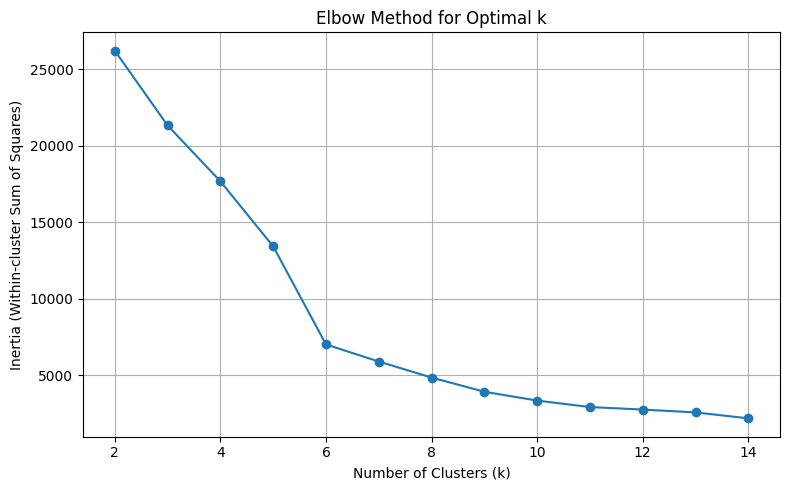

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Reload cleaned feature matrix
feature_matrix = skill_feature_df.copy()
feature_matrix = feature_matrix.dropna(subset=["Avg_Salary"])

# Select and scale features
selected_features = [
    "Frequency", "Doc_Freq_%", "Co_Occurrence_Count", "Unique_Co_Skills",
    "Avg_Skills_Per_Post", "Appears_in_Title", "Avg_Salary", "Pct_Remote", "Pct_Senior"
]

X = feature_matrix[selected_features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Elbow Method
from sklearn.cluster import KMeans
inertia_scores = []
K_range = range(2, 15)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia_scores.append(kmeans.inertia_)

# Plot Elbow curve
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia_scores, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Within-cluster Sum of Squares)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Run K-means clustering with k = 8
kmeans_final = KMeans(n_clusters=8, random_state=42)
clusters = kmeans_final.fit_predict(X_scaled)

# Add cluster labels to the original skill feature matrix
clustered_skills = feature_matrix.copy()
clustered_skills["Cluster"] = clusters + 1

# Group skills by cluster for curriculum planning
grouped_clusters = clustered_skills.groupby("Cluster")["Skill"].apply(list).reset_index()
grouped_clusters["Course_ID"] = grouped_clusters["Cluster"].apply(lambda x: f"Course_{x}")
grouped_clusters

,Cluster,Skill,Course_ID
0,1,"[forecasting, financial analysis, process impr...",Course_1
1,2,"[financial modeling, predictive modeling, SAS,...",Course_2
2,3,"[data storage, honesty, relevant experience, s...",Course_3
3,4,"[FP&A, financial management, strategic decisio...",Course_4
4,5,"[Dynamic Media, Forms, Screens, Assets, Sites,...",Course_5
5,6,"[planning, software development, design, Hadoo...",Course_6
6,7,"[Sqoop, Hive, HBase, Microsoft Excel, healthca...",Course_7
7,8,"[leadership, communication, teamwork, problem-...",Course_8


In [ ]:
# View each course with all skills listed in full
for i, row in grouped_clusters.iterrows():
    print(f"\n {row['Course_ID']} (Cluster {row['Cluster']})")
    print("-" * 60)
    for skill in row['Skill']:
        print(f"• {skill}")

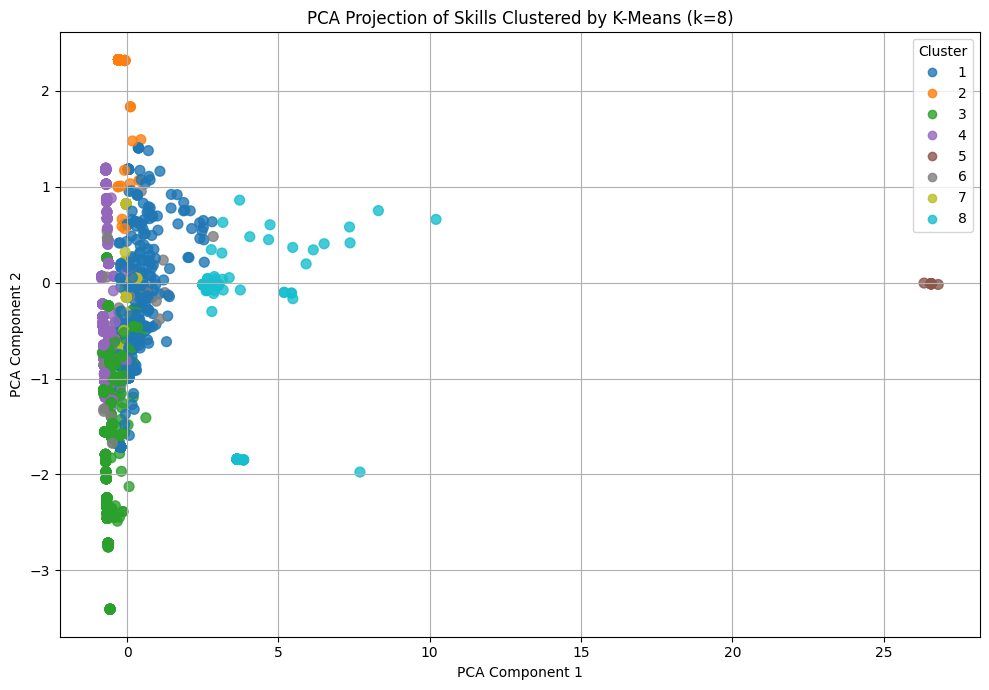

In [ ]:
from sklearn.decomposition import PCA

# Apply PCA to reduce dimensionality to 2 components for plotting
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Use same K-means results from earlier (k=8)
cluster_labels = clustered_skills["Cluster"].values
skill_names = clustered_skills["Skill"].values

# Plot the PCA-reduced clusters
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='tab10', alpha=0.8, s=50)
plt.title("PCA Projection of Skills Clustered by K-Means (k=8)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score

# Compute silhouette score (higher is better, max = 1.0)
sil_score = silhouette_score(X_scaled, clusters)

print(f"Silhouette Score (k=8): {sil_score:.4f}")

Silhouette Score (k=8): 0.6390


### Q4 - Ensemble Method

In [ ]:
# Load both sets of clustering results
# 1. Hierarchical clustering labels (Q2)

skill_clusters_q2 = skill_clusters_clean.rename(columns={"Cluster": "Cluster_Hierarchical"})

# 2. K-means clustering labels (Q3)
skill_clusters_q3 = clustered_skills[["Skill", "Cluster"]].rename(columns={"Cluster": "Cluster_KMeans"})

# Merge both cluster labels on skill
ensemble_clusters = pd.merge(skill_clusters_q2, skill_clusters_q3, on="Skill", how="inner")

# Create a combined cluster label (tuple of both methods)
ensemble_clusters["Ensemble_Label"] = list(zip(
    ensemble_clusters["Cluster_Hierarchical"],
    ensemble_clusters["Cluster_KMeans"]
))

# Group by ensemble label
ensemble_grouped = ensemble_clusters.groupby("Ensemble_Label")["Skill"].apply(list).reset_index()
ensemble_grouped["Ensemble_Cluster_ID"] = ensemble_grouped.index + 1
ensemble_grouped

,Ensemble_Label,Skill,Ensemble_Cluster_ID
0,"(1, 6)","[analytics, data science]",1
1,"(2, 1)","[Power BI, Python, AWS, SQL, Spark, Tableau, a...",2
2,"(2, 2)",[predictive modeling],3
3,"(2, 6)","[Hadoop, AI, R, business intelligence, machine...",4
4,"(2, 8)","[accountability, creativity, data analysis, re...",5
5,"(3, 1)",[artificial intelligence],6
6,"(4, 1)",[data pipelines],7
7,"(4, 4)",[data cleaning],8
8,"(5, 3)","[data interpretation, data modeling]",9
9,"(6, 6)",[marketing],10


### Q5

In [ ]:
from openai import OpenAI

client = OpenAI(
    api_key="",
    base_url="https://api.deepseek.com"
)


In [ ]:
# Format course content as text
course_overview = "\n".join(
    f"{row['Course_ID']}: {', '.join(row['Skills'])}"
    for _, row in final_course_df.iterrows()
)

# Prompt to generate a pitch-style curriculum overview
prompt_1 = f"""
You are a marketing writer for a new tech education program. Below is a list of courses with their associated skills:

{course_overview}

Write a short, enticing description of this curriculum that would encourage students or working professionals to enroll. Highlight the variety of topics and industry relevance.
"""

# Call the model
response_1 = client.chat.completions.create(
    model="deepseek-chat",
    messages=[{"role": "user", "content": prompt_1}],
    temperature=0.7
)
curriculum_description = response_1.choices[0].message.content


In [ ]:
# Prompt to analyze patterns in the clusters
prompt_2 = f"""
Here is a breakdown of skill clusters from a data science and analytics curriculum:

{course_overview}

Analyze and describe the similarities or themes within each course. Identify patterns such as which are technical, which are managerial, and which focus on soft skills.
"""

response_2 = client.chat.completions.create(
    model="deepseek-chat",
    messages=[{"role": "user", "content": prompt_2}],
    temperature=0.5
)
cluster_analysis = response_2.choices[0].message.content

In [ ]:
print("=== Course Marketing Description ===\n")
print(curriculum_description)

print("\n=== Cluster Similarity Analysis ===\n")
print(cluster_analysis)

=== Course Marketing Description ===

**Unlock Your Future in Tech with Our Cutting-Edge Data & AI Program!**  

Master the skills that power today’s most in-demand careers with our comprehensive tech education curriculum. Whether you're a beginner or a working professional, our program covers everything from **data engineering, AI, and machine learning** to **business strategy and professional development**.  

- **Build technical expertise** with hands-on training in Hadoop, Spark, Python, SQL, and AWS.  
- **Transform data into insights** using Tableau, Power BI, and advanced statistical modeling.  
- **Develop AI and predictive models** with machine learning and deep learning techniques.  
- **Lead with strategy** by mastering project management, risk assessment, and business intelligence.  
- **Sharpen professional skills** like communication, problem-solving, and collaboration to thrive in any data role.  

Designed for real-world impact, this program equips you with the **versat